In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Encoder/Freq'

/content/drive/My Drive/Siamese/Encoder/Freq


In [3]:
import sys
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

In [4]:
!pip install torchaudio

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 1

torch.backends.cudnn.deterministic = True
B = 64

WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
NUM_WORKERS = 4

NUM_CLASSES = 200

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [7]:
from Normalize import Normalize
from ToTensor import ToTensor
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])


In [8]:
from TransFourier import TransFourier

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = TransFourier(pairwise=True)
encoder_path = '/content/drive/My Drive/Siamese/Encoder/Saved/encoder_frequency_1.pt'
net.load_state_dict(torch.load(encoder_path))
net.to(DEVICE)

cuda


TransFourier(
  (spectrogram): Spectrogram()
  (amp): AmplitudeToDB()
  (block1): Conv2DBlock(
    (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Conv2DBlock(
    (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Conv2DBlock(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(256, 192, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1

In [9]:
import numpy as np

max_accuracy = 0
test_accuracy1 = []

test_loss = 0
test_losses1 = []

net.eval()
print("*** Test ***")

for cross_id in range(1, 10):
    print("*** Cross id ", cross_id, " ***")
    
    testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=1,
                                return_type=ReturnType.ENCODER,
                                cross_id=cross_id)
    testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=4, 
                                            num_workers=NUM_WORKERS)

    # test    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (label, a, p, n_label, n) in tqdm(enumerate(testsetloader)):
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        loss, results, a, p, n = net(a, p , n)

        # Calculate loss
        test_loss += loss.item()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1
    
    accuracy /= nb_test
    test_accuracy1.append(accuracy)
    print("accuracy = ", accuracy)
    test_loss /= len(testsetloader)
    test_losses1.append(test_loss)
    print("loss = ", test_loss)

*** Test ***
*** Cross id  1  ***
sample lenght  1 seconds


659it [00:12, 51.48it/s]


accuracy =  0.768413059984814
loss =  0.7086457324317446
*** Cross id  2  ***
sample lenght  1 seconds


582it [03:40,  2.64it/s]


accuracy =  0.8580645161290322
loss =  0.44817132930580345
*** Cross id  3  ***
sample lenght  1 seconds


673it [03:40,  3.06it/s]


accuracy =  0.8449814126394052
loss =  0.4846182470155834
*** Cross id  4  ***
sample lenght  1 seconds


482it [02:29,  3.22it/s]


accuracy =  0.8293568464730291
loss =  0.523156479558475
*** Cross id  5  ***
sample lenght  1 seconds


630it [03:32,  2.96it/s]


accuracy =  0.8303535955502582
loss =  0.5419683117014408
*** Cross id  6  ***
sample lenght  1 seconds


555it [03:24,  2.71it/s]


accuracy =  0.8539224526600541
loss =  0.4522099538354799
*** Cross id  7  ***
sample lenght  1 seconds


592it [03:22,  2.93it/s]


accuracy =  0.8465116279069768
loss =  0.483033327544143
*** Cross id  8  ***
sample lenght  1 seconds


859it [06:49,  2.10it/s]


accuracy =  0.8675785797438882
loss =  0.40311669231095376
*** Cross id  9  ***
sample lenght  1 seconds


498it [06:38,  1.25it/s]

accuracy =  0.8669010547463586
loss =  0.4019531866537168


In [10]:
from TransFourier import TransFourier

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = TransFourier(pairwise=True)
encoder_path = '/content/drive/My Drive/Siamese/Encoder/Saved/encoder_frequency_2.pt'
net.load_state_dict(torch.load(encoder_path))
net.to(DEVICE)

cuda


TransFourier(
  (spectrogram): Spectrogram()
  (amp): AmplitudeToDB()
  (block1): Conv2DBlock(
    (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Conv2DBlock(
    (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Conv2DBlock(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(256, 192, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1

In [11]:
import numpy as np

max_accuracy = 0
test_accuracy2 = []

test_loss = 0
test_losses2 = []

net.eval()
print("*** Test ***")

for cross_id in range(1, 10):
    print("*** Cross id ", cross_id, " ***")
    
    testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=2,
                                return_type=ReturnType.ENCODER,
                                cross_id=cross_id)
    testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=4, 
                                            num_workers=NUM_WORKERS)

    # test    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (label, a, p, n_label, n) in tqdm(enumerate(testsetloader)):
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        loss, results, a, p, n = net(a, p , n)

        # Calculate loss
        test_loss += loss.item()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1
    
    accuracy /= nb_test
    test_accuracy2.append(accuracy)
    print("accuracy = ", accuracy)
    test_loss /= len(testsetloader)
    test_losses2.append(test_loss)
    print("loss = ", test_loss)

*** Test ***
*** Cross id  1  ***
sample lenght  2 seconds


659it [00:16, 39.50it/s]

accuracy =  0.7915717539863326
loss =  0.6635138215172092
*** Cross id  2  ***
sample lenght  2 seconds



582it [00:14, 39.61it/s]

accuracy =  0.8662365591397849
loss =  0.4279075549335598
*** Cross id  3  ***
sample lenght  2 seconds



673it [00:16, 39.69it/s]


accuracy =  0.862453531598513
loss =  0.42187255802313534
*** Cross id  4  ***
sample lenght  2 seconds


482it [00:12, 39.66it/s]

accuracy =  0.8490663900414938
loss =  0.46963404014279075
*** Cross id  5  ***
sample lenght  2 seconds



630it [00:15, 39.39it/s]

accuracy =  0.8450536352800954
loss =  0.4653187192368534
*** Cross id  6  ***
sample lenght  2 seconds



555it [00:14, 39.57it/s]

accuracy =  0.8724075743913435
loss =  0.39696796183773847
*** Cross id  7  ***
sample lenght  2 seconds



592it [00:14, 39.51it/s]

accuracy =  0.8621564482029598
loss =  0.4155547454994304
*** Cross id  8  ***
sample lenght  2 seconds



859it [00:21, 39.63it/s]

accuracy =  0.880093131548312
loss =  0.36665839100640846
*** Cross id  9  ***
sample lenght  2 seconds



498it [00:12, 39.57it/s]

accuracy =  0.8950276243093923
loss =  0.313277704172839


In [12]:
from TransFourier import TransFourier

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = TransFourier(pairwise=True)
encoder_path = '/content/drive/My Drive/Siamese/Encoder/Saved/encoder_frequency_3.pt'
net.load_state_dict(torch.load(encoder_path))
net.to(DEVICE)

cuda


TransFourier(
  (spectrogram): Spectrogram()
  (amp): AmplitudeToDB()
  (block1): Conv2DBlock(
    (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Conv2DBlock(
    (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Conv2DBlock(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(256, 192, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1

In [13]:
import numpy as np

max_accuracy = 0
test_accuracy3 = []

test_loss = 0
test_losses3 = []

net.eval()
print("*** Test ***")

for cross_id in range(1, 10):
    print("*** Cross id ", cross_id, " ***")
    
    testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.ENCODER,
                                cross_id=cross_id)
    testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=4, 
                                            num_workers=NUM_WORKERS)

    # test    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (label, a, p, n_label, n) in tqdm(enumerate(testsetloader)):
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        loss, results, a, p, n = net(a, p , n)

        # Calculate loss
        test_loss += loss.item()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1
    
    accuracy /= nb_test
    test_accuracy3.append(accuracy)
    print("accuracy = ", accuracy)
    test_loss /= len(testsetloader)
    test_losses3.append(test_loss)
    print("loss = ", test_loss)

*** Test ***
*** Cross id  1  ***
sample lenght  3 seconds


659it [00:22, 29.46it/s]

accuracy =  0.8116932422171602
loss =  0.6016483554709844
*** Cross id  2  ***
sample lenght  3 seconds



582it [00:19, 29.49it/s]

accuracy =  0.8821505376344086
loss =  0.3761279214714587
*** Cross id  3  ***
sample lenght  3 seconds



673it [00:22, 29.55it/s]


accuracy =  0.866914498141264
loss =  0.3970391174112137
*** Cross id  4  ***
sample lenght  3 seconds


482it [00:16, 29.37it/s]

accuracy =  0.8526970954356846
loss =  0.4479882187904235
*** Cross id  5  ***
sample lenght  3 seconds



630it [00:21, 29.40it/s]

accuracy =  0.8633293603496226
loss =  0.42168128160371693
*** Cross id  6  ***
sample lenght  3 seconds



555it [00:18, 29.29it/s]

accuracy =  0.8999098286744815
loss =  0.32278485501613946
*** Cross id  7  ***
sample lenght  3 seconds



592it [00:20, 28.96it/s]

accuracy =  0.879492600422833
loss =  0.37652119452829846
*** Cross id  8  ***
sample lenght  3 seconds



859it [00:29, 29.53it/s]

accuracy =  0.9048311990686845
loss =  0.2973478437447839
*** Cross id  9  ***
sample lenght  3 seconds



498it [00:16, 29.51it/s]

accuracy =  0.9196383726770467
loss =  0.2537361799954459


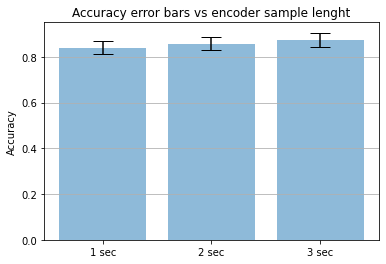

In [19]:
import numpy as np
import matplotlib.pyplot as plt

mean1 = np.mean(test_accuracy1)
std1 = np.std(test_accuracy1)
mean2 = np.mean(test_accuracy2)
std2 = np.std(test_accuracy2)
mean3 = np.mean(test_accuracy3)
std3 = np.std(test_accuracy3)

mean = [mean1, mean2, mean3]
std = [std1, std2, std3]
labels = ['1 sec', '2 sec', '3 sec']
x_pos = np.arange(len(labels))

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, 
       mean,
       yerr=std,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Accuracy error bars vs encoder sample lenght')
ax.yaxis.grid(True)





In [16]:
print(mean)
print(std)

[0.8406759050926463, 0.8582296276109141, 0.8756285260690206]
[0.02867156972678909, 0.02755063135094935, 0.03032689833337266]
